1. Problem Statement

Pain Point: Canadians face growing financial fraud and spending management challenges (Scotiabank 2025 survey: majority targeted by scams, lack of trust in detection).
Business Problem: Banks need actionable insights to prioritize prevention, enhance customer trust, and improve digital services.

Key Questions:

What are the major pain points reported by customers in surveys?

Can we categorize these into themes for bank strategy?

How can data science techniques like NLP, topic modeling, and visualization help stakeholders quickly understand the key issues?

2. Data Sources

Primary Survey Data: Scotiabank 2025 fraud & scam survey (link
)

Contains percentages of Canadians impacted by fraud, scam types, confidence levels in banks, etc.

Synthetic Dataset Creation (for demonstration, as raw survey text may not be fully available)

Generate fake customer feedback reflecting pain points:

Fraud attempts

Spending issues

Trust in banking apps

Digital service frustrations

In [14]:
import pandas as pd
import random

# Define lists of positive and negative feedback examples
positive_feedback_examples = [
    "The banking app is easy to use and intuitive.",
    "Customer service was very helpful and quick.",
    "I feel secure using my bank's digital services.",
    "The bank provides useful financial advice and guidance.",
    "Transactions are fast and reliable.",
    "I am satisfied with fraud protection measures.",
    "My spending tracking dashboard is very convenient.",
    "The bank responds promptly to my queries.",
    "Mobile banking makes life so much easier.",
    "I trust the bank to protect my money."
]

negative_feedback_examples = [
    "I received phishing emails and I am worried about losing money.",
    "Bank app is confusing and hard to navigate.",
    "Fraud alerts are too slow to react.",
    "I cannot track my spending efficiently.",
    "AI-based fraud detection sometimes flags legit transactions.",
    "Customer service takes too long to respond.",
    "I want better financial guidance from my bank.",
    "Digital payments feel risky due to scams.",
    "I often get charged hidden fees I don’t understand.",
    "The online platform crashes frequently."
]

# Function to randomly create synthetic feedback
def generate_feedback(n_positive, n_negative):
    data = []

    for _ in range(n_positive):
        sentence = random.choice(positive_feedback_examples)
        data.append({"feedback": sentence, "sentiment": "positive"})
    
    for _ in range(n_negative):
        sentence = random.choice(negative_feedback_examples)
        data.append({"feedback": sentence, "sentiment": "negative"})
    
    return pd.DataFrame(data)

# Generate 10,000+ points (50% positive, 50% negative)
n_total = 10000
df_synthetic = generate_feedback(n_total//2, n_total//2)

# Shuffle dataset
df_synthetic = df_synthetic.sample(frac=1, random_state=42).reset_index(drop=True)

# Check sample
df_synthetic.head(10)
df = df_synthetic.copy()

3. Data Preprocessing

Text Cleaning Steps:

Lowercasing

Remove punctuation, stopwords

Tokenization

Lemmatization

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

df['cleaned_feedback'] = df['feedback'].apply(clean_text)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manpr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manpr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manpr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,feedback,sentiment,cleaned_feedback
0,I often get charged hidden fees I don’t unders...,negative,often get charged hidden fee dont understand
1,The bank responds promptly to my queries.,positive,bank responds promptly query
2,The bank provides useful financial advice and ...,positive,bank provides useful financial advice guidance
3,My spending tracking dashboard is very conveni...,positive,spending tracking dashboard convenient
4,The bank provides useful financial advice and ...,positive,bank provides useful financial advice guidance


4. Exploratory Analysis — Word Cloud

Visualize common words to quickly highlight pain points.

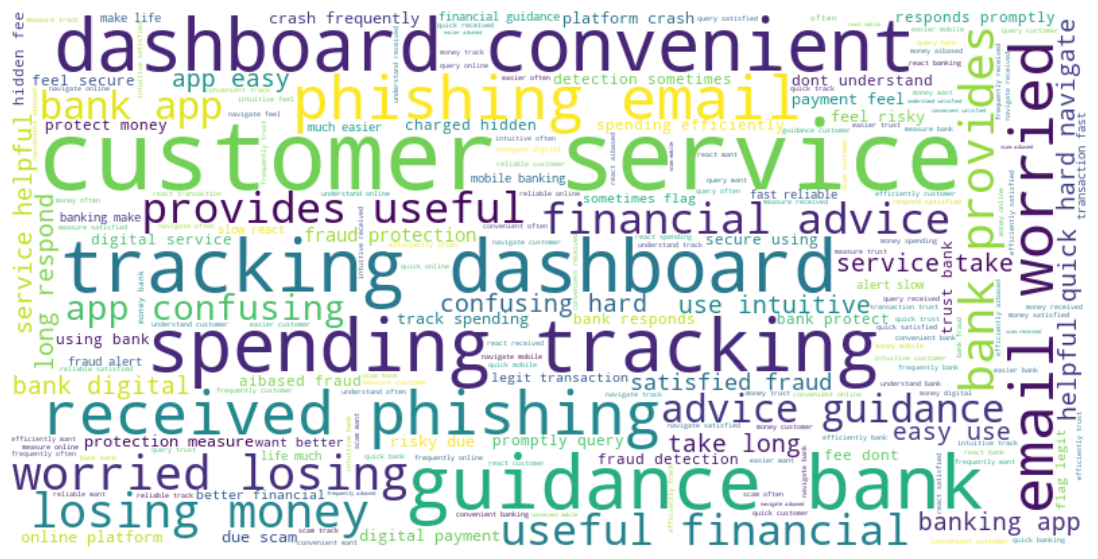

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df['cleaned_feedback'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

5. Topic Modeling — Discover Themes

Use Latent Dirichlet Allocation (LDA) to identify key topics in customer feedback.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize
vectorizer = CountVectorizer(max_df=0.95, min_df=1, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_feedback'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Display topics
def display_topics(model, feature_names, no_top_words):
    topics = []
    for idx, topic in enumerate(model.components_):
        topics.append([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topics

topics = display_topics(lda, vectorizer.get_feature_names_out(), 5)
for i, t in enumerate(topics):
    print(f"Topic {i+1}: {t}")

Topic 1: ['bank', 'app', 'spending', 'transaction', 'convenient']
Topic 2: ['customer', 'digital', 'feel', 'service', 'respond']
Topic 3: ['money', 'service', 'bank', 'email', 'phishing']


6. Dictionary Creation for Pain Points

You can create custom dictionaries to categorize issues:

In [18]:
pain_dict = {
    "Fraud": ["fraud", "scam", "alert", "risk", "money"],
    "Digital Experience": ["app", "navigate", "digital", "service", "slow"],
    "Spending & Guidance": ["spending", "track", "guidance", "efficiency", "budget"]
}

# Map feedback to categories
def map_pain(text):
    categories = []
    for key, words in pain_dict.items():
        if any(w in text for w in words):
            categories.append(key)
    return categories

df['pain_categories'] = df['cleaned_feedback'].apply(map_pain)
df

,feedback,sentiment,cleaned_feedback,pain_categories
0,I often get charged hidden fees I don’t unders...,negative,often get charged hidden fee dont understand,[]
1,The bank responds promptly to my queries.,positive,bank responds promptly query,[]
2,The bank provides useful financial advice and ...,positive,bank provides useful financial advice guidance,[Spending & Guidance]
3,My spending tracking dashboard is very conveni...,positive,spending tracking dashboard convenient,[Spending & Guidance]
4,The bank provides useful financial advice and ...,positive,bank provides useful financial advice guidance,[Spending & Guidance]
...,...,...,...,...
9995,Customer service takes too long to respond.,negative,customer service take long respond,[Digital Experience]
9996,Bank app is confusing and hard to navigate.,negative,bank app confusing hard navigate,[Digital Experience]
9997,I received phishing emails and I am worried ab...,negative,received phishing email worried losing money,[Fraud]
9998,I trust the bank to protect my money.,positive,trust bank protect money,[Fraud]


7. Outcome Visualization for Stakeholders

Bar chart of pain points frequency

Word cloud per topic

Topic modeling summary table

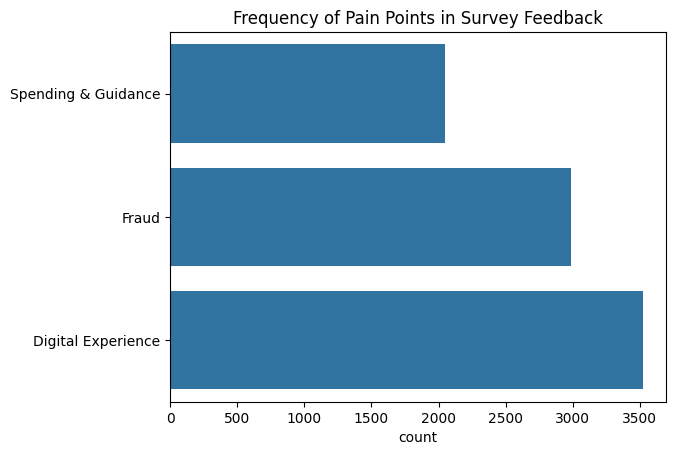

In [19]:
import seaborn as sns

# Flatten list of categories
all_categories = [cat for sublist in df['pain_categories'] for cat in sublist]
sns.countplot(y=all_categories)
plt.title("Frequency of Pain Points in Survey Feedback")
plt.show()

Insights for Stakeholders:

Fraud-related concerns dominate (high frequency) → Immediate need for better fraud detection.

Digital app usability is second priority → UX redesign recommended.

Spending & guidance tools are emerging concerns → Introduce budgeting dashboards and AI-based guidance.

8. So What? Business Implications

Fraud Prevention: Deploy AI-based real-time alerts, educate customers on phishing and scam tactics.

Digital Experience: Simplify app navigation, improve customer support channels, and integrate proactive notifications.

Financial Guidance & Spending: Introduce personalized dashboards, budgeting tools, and investment education modules.

Communication: Visualizations (word clouds, topic bar charts) provide clear, digestible insights for executives and stakeholders.

Production alternative for Azure eco system - Image 